In [1]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)

#REGRESIÓN LOGÍSTICA MULTICLASS
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm


In [2]:
data=pd.read_excel(r"D:\Never Urueta\2023\Tesis\Data.xlsx") 

In [3]:
data1 = data1 = data.drop(["PBA", "CF", "Indicador", "DESTINO", "CAPACIDAD DEL CUARTO FRIO  "], axis=1)

In [ ]:
data1["Rechazados_Multiclass"] = data1["Rechazados"] 
data1.loc[data1["Rechazados_Multiclass"] > 1, "Rechazados_Multiclass"] = 2

In [38]:
print("No Rechazados = 0, Rechazados solo una vez = 1, Rechazados dos o más veces = 2:")
print("-------------------------------------------------------------------------------")
print(data1.Rechazados_Multiclass.value_counts().sort_index())

No Rechazados = 0, Rechazados solo una vez = 1, Rechazados dos o más veces = 2:
-------------------------------------------------------------------------------
0    1329
1     222
2     363
Name: Rechazados_Multiclass, dtype: int64


# <span style="color:darkred"> Umbral de Clasificación Esperado
<span style="color:darkblue"> En el 69.4% de las maduraciones No se rechazan canales, en el 11.6% se rechaza solo un canal y en el 19% de dichas maduraciones se rechazan dos o más canales. Un modelo de clasificación que sea útil debe de ser capaz de predecir correctamente un porcentaje de observaciones totales por encima del porcentaje de la clase mayoritaria. En este caso, el umbral de referencia que se tiene que superar es del 69.4%.

# <span style="color:darkred"> Variables

In [5]:
###VARIABLES CATEGORICAS Y NUMERICAS
features = list(set(data1.columns.values) - set(['ID', 'TARGET']))
cat_features = [feat for feat in features if data1[feat].dtype.name in ['category', 'object']]
num_features = list(set(features) - set(cat_features))

print(f"Factores Categoricos: \n {cat_features}")
print(f"Factores Numéricos: \n {num_features}")

Factores Categoricos: 
 ['Franja2', 'Franja1', 'Refrigeracion', 'TIPO_CAP_CF', 'pH_Requisito', 'Dia_Semana']
Factores Numéricos: 
 ['Tamin', 'Temp1', 'Canales', 'Rechazados', 'Taamax', 'Ti1', 'VT1', 'VT2', 'PPPCF', 'Ti2', 'Rechazados_Multiclass', 'Ocupacion', 'Temp2', 'Temp3']


## <span style="color:darkgreen"> Datos Faltantes

In [6]:
data1.isnull().sum() #Datos faltantes

Dia_Semana                0
Temp1                     0
Franja1                   0
Temp2                     0
Franja2                   0
VT1                       0
Ti1                       0
Temp3                     0
Ti2                       0
VT2                       0
Refrigeracion             0
Canales                   0
PPPCF                     0
Ocupacion                 0
pH_Requisito              0
Tamin                    29
Taamax                   29
TIPO_CAP_CF               0
Rechazados                0
Rechazados_Multiclass     0
dtype: int64

In [7]:
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


## <span style="color:darkgreen"> Variables Numericas

In [8]:
data1.describe()

,Temp1,Temp2,VT1,Ti1,Temp3,Ti2,VT2,Canales,PPPCF,Ocupacion,Tamin,Taamax,Rechazados,Rechazados_Multiclass
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,3.080371,11.733454,8.653083,2.129855,2.766437,33.368273,-8.955836,136.827586,22.518286,93.083697,23.857913,32.530543,0.552247,0.495298
std,1.614204,3.365969,3.251896,1.135182,1.774718,14.483894,3.597810,30.208935,15.420267,11.038884,0.960839,1.664524,0.930765,0.793484
min,-4.700000,1.400000,-3.200000,0.166667,-5.600000,24.000000,-35.200000,27.000000,3.991370,19.354839,20.400000,27.200000,0.000000,0.000000
25%,2.100000,10.000000,6.800000,1.583333,2.000000,24.250000,-10.900000,140.000000,17.022934,91.888046,23.300000,31.600000,0.000000,0.000000
50%,2.900000,11.500000,8.500000,1.883333,3.000000,25.250000,-9.000000,150.000000,19.326683,96.774194,24.000000,32.600000,0.000000,0.000000
75%,3.900000,13.800000,10.500000,2.483333,3.800000,37.757500,-7.000000,155.000000,23.219814,100.000000,24.500000,33.600000,1.000000,1.000000
max,18.200000,39.400000,36.800000,16.183333,7.300000,110.200000,4.200000,239.000000,100.000000,104.761905,26.000000,36.300000,5.000000,2.000000


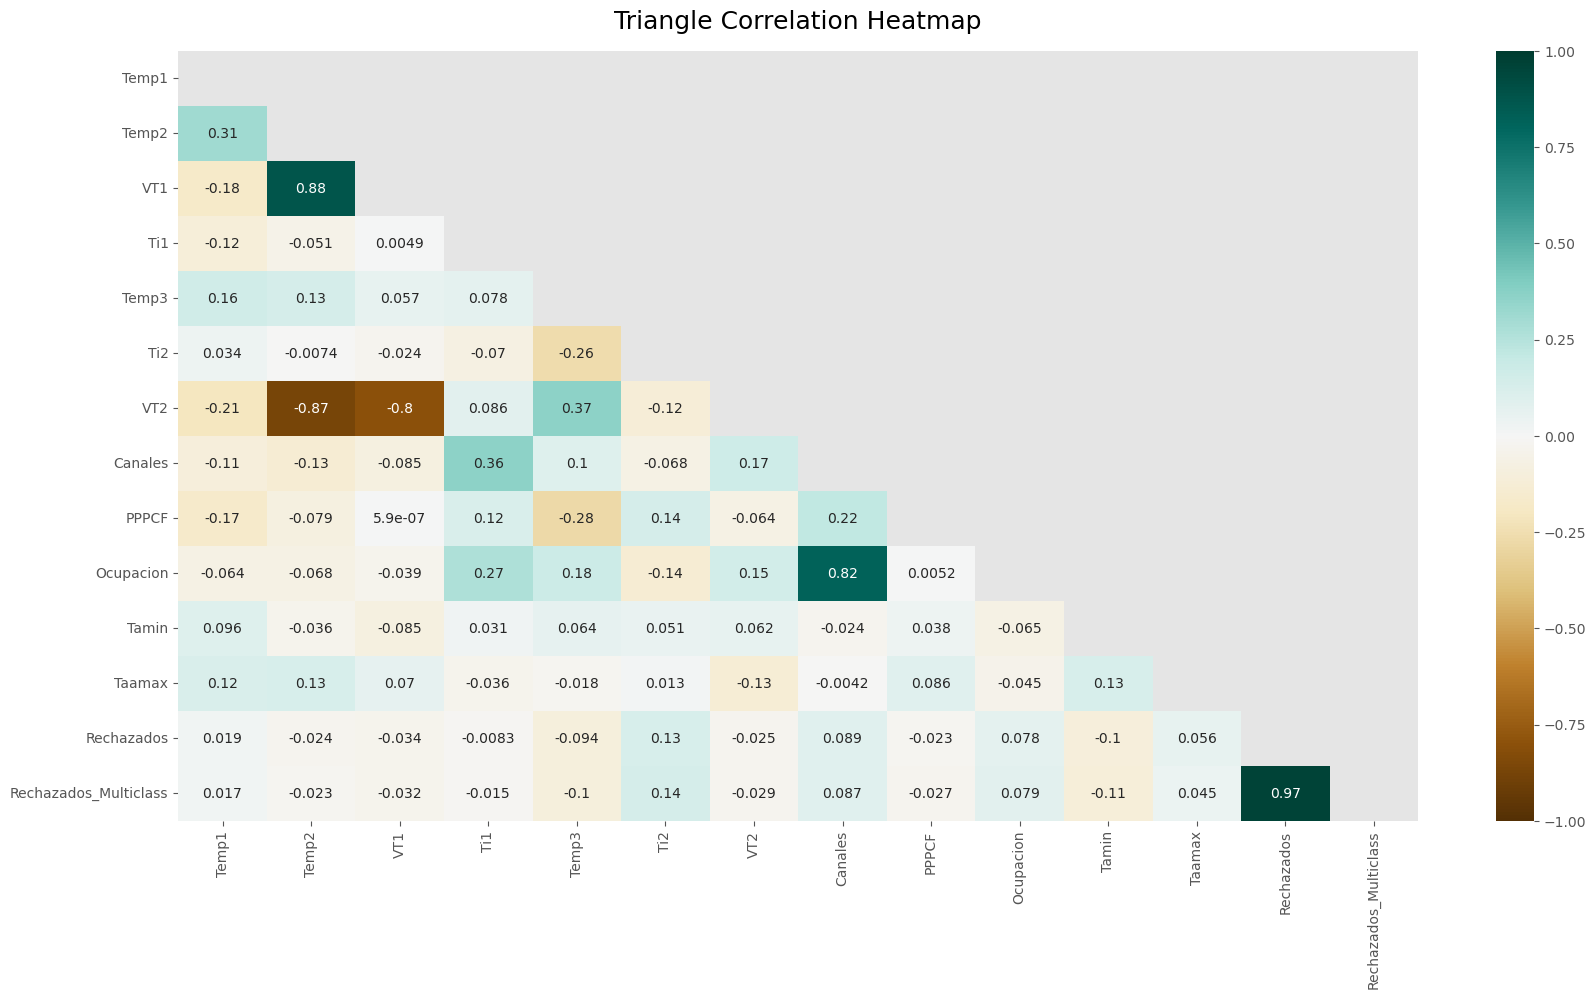

In [9]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(data1.corr(), dtype=np.bool))
heatmap = sns.heatmap(data1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

In [10]:
data1 = data1.drop(["VT1", "VT2", "Rechazados", "Canales"], axis=1)

## <span style="color:darkgreen"> Variables Categóricas 

<span style="color:darkblue"> Las variables categóricas se combierten en variables dummys, el número de nuevas variables corresponderán al numero de factores menos 1 para evitar multicolinealdad

In [11]:
data1 = pd.get_dummies(data1, drop_first = True, columns = ["Franja1", "Franja2", "Dia_Semana"]) # el parámetro drop first la primera categoría, para evitar problemas de multicolinealidad
data1 = pd.get_dummies(data1, columns = ["Refrigeracion", "pH_Requisito", "TIPO_CAP_CF"]) 

In [12]:
data1 = data1.drop(["Refrigeracion_GLICOL", "pH_Requisito_Mi_6", "TIPO_CAP_CF_PBA2"], axis=1)

In [13]:
data1.columns

Index(['Temp1', 'Temp2', 'Ti1', 'Temp3', 'Ti2', 'PPPCF', 'Ocupacion', 'Tamin',
       'Taamax', 'Rechazados_Multiclass', 'Franja1_MAÑANA',
       'Franja1_MEDIO_DIA', 'Franja1_NOCHE', 'Franja1_TARDE', 'Franja2_MAÑANA',
       'Franja2_MEDIO_DIA', 'Franja2_NOCHE', 'Franja2_TARDE',
       'Dia_Semana_lunes', 'Dia_Semana_martes', 'Dia_Semana_miércoles',
       'Dia_Semana_sábado', 'Dia_Semana_viernes', 'Refrigeracion_AMONIACO',
       'pH_Requisito_Mi_5.8', 'TIPO_CAP_CF_C1', 'TIPO_CAP_CF_C2',
       'TIPO_CAP_CF_C3'],
      dtype='object')

# <span style="color:darkred"> Primer Modelo Logístico Multiclase con Multicolinealidad

In [39]:
data1 = sm.add_constant(data1)
modelo=sm.MNLogit(data1["Rechazados_Multiclass"], data1.drop(["Rechazados_Multiclass"], axis=1))
modelo=modelo.fit()
modelo.summary()

Optimization terminated successfully.
         Current function value: 0.754661
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     Rechazados_Multiclass   No. Observations:                 1914
Model:                           MNLogit   Df Residuals:                     1870
Method:                              MLE   Df Model:                           42
Date:                   Wed, 19 Jul 2023   Pseudo R-squ.:                 0.07795
Time:                           23:07:27   Log-Likelihood:                -1444.4
converged:                          True   LL-Null:                       -1566.5
Covariance Type:               nonrobust   LLR p-value:                 2.480e-30
===========================================================================================
Rechazados_Multiclass=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.7602      2.407      2.393      0.017       1.042      10.478
Temp1                      -0.1557      0.062     -2.510      0.012      -0.277      -0.034
Temp2                       0.0200      0.024      0.826      0.409      -0.027       0.068
Ti1                         0.0840      0.060      1.403      0.161      -0.033       0.201
Temp3                      -0.1111      0.045     -2.450      0.014      -0.200      -0.022
Ti2                         0.0240      0.006      4.359      0.000       0.013       0.035
PPPCF                      -0.0292      0.009     -3.293      0.001      -0.047      -0.012
Ocupacion                  -0.0041      0.009     -0.462      0.644      -0.021       0.013
Tamin                      -0.2729      0.077     -3.531      0.000      -0.424      -0.121
Taamax                     -0.0304      0.046     -0.667      0.505      -0.120       0.059
Franja2_MAÑANA             -0.4298      0.284     -1.515      0.130      -0.986       0.126
Franja2_MEDIO_DIA          -0.4634      0.229     -2.019      0.043      -0.913      -0.014
Franja2_NOCHE              -0.3648      0.186     -1.966      0.049      -0.728      -0.001
Dia_Semana_lunes            0.3384      0.259      1.305      0.192      -0.170       0.847
Dia_Semana_martes           0.1744      0.256      0.681      0.496      -0.327       0.676
Dia_Semana_miércoles        0.2199      0.252      0.873      0.383      -0.274       0.714
Dia_Semana_sábado          -0.3805      0.273     -1.395      0.163      -0.915       0.154
Dia_Semana_viernes         -0.3441      0.274     -1.255      0.210      -0.882       0.193
Refrigeracion_AMONIACO      0.1616      0.185      0.876      0.381      -0.200       0.523
pH_Requisito_Mi_5.8         0.3703      0.184      2.015      0.044       0.010       0.730
TIPO_CAP_CF_C2              0.3019      0.384      0.787      0.431      -0.450       1.054
TIPO_CAP_CF_C3              0.3534      0.313      1.129      0.259      -0.260       0.967
-------------------------------------------------------------------------------------------
Rechazados_Multiclass=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.8730      2.113     -0.413      0.679      -5.014       3.268
Temp1                       0.0450      0.042      1.084      0.278      -0.036       0.127
Temp2                      -0.0287      0.021     -1.348      0.178      -0.070       0.013
Ti1                        -0.1928      0.080     -2.395      0.017      -0.351      -0.035
Temp3                      -0.1420      0.038     -3.779      0.000      -0.216      -0.068
Ti2                         0.0293      0.005      6.316      0.000       0.020       0.038
PPPCF                      -0.0025      0.006     -0.394      0.693      -0.015       


## <span style="color:darkgreen"> Detectando y Eliminando Multicolinealidad 

In [40]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Multiclass"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Multiclass"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Multiclass"], axis=1).columns)   

const                     1088.221820
Temp1                        1.225575
Temp2                        1.239589
Ti1                          1.199346
Temp3                        1.255308
Ti2                          1.261597
PPPCF                        1.495837
Ocupacion                    1.809575
Tamin                        1.063604
Taamax                       1.077512
Franja2_MAÑANA               1.166764
Franja2_MEDIO_DIA            1.218223
Franja2_NOCHE                1.220249
Dia_Semana_lunes             1.693455
Dia_Semana_martes            1.702634
Dia_Semana_miércoles         1.710340
Dia_Semana_sábado            1.765796
Dia_Semana_viernes           1.744278
Refrigeracion_AMONIACO       1.496863
pH_Requisito_Mi_5.8          1.144664
TIPO_CAP_CF_C2               1.743096
TIPO_CAP_CF_C3               2.697078
dtype: float64

In [16]:
#Eliminando la Multicolinealidad
data1 = data1.drop([ "Franja1_MAÑANA", "Franja1_MEDIO_DIA","Franja1_NOCHE", "Franja1_TARDE", "Franja2_TARDE", "TIPO_CAP_CF_C1"], axis=1)

In [17]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Multiclass"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Multiclass"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Multiclass"], axis=1).columns)   

const                     1088.221820
Temp1                        1.225575
Temp2                        1.239589
Ti1                          1.199346
Temp3                        1.255308
Ti2                          1.261597
PPPCF                        1.495837
Ocupacion                    1.809575
Tamin                        1.063604
Taamax                       1.077512
Franja2_MAÑANA               1.166764
Franja2_MEDIO_DIA            1.218223
Franja2_NOCHE                1.220249
Dia_Semana_lunes             1.693455
Dia_Semana_martes            1.702634
Dia_Semana_miércoles         1.710340
Dia_Semana_sábado            1.765796
Dia_Semana_viernes           1.744278
Refrigeracion_AMONIACO       1.496863
pH_Requisito_Mi_5.8          1.144664
TIPO_CAP_CF_C2               1.743096
TIPO_CAP_CF_C3               2.697078
dtype: float64

# <span style="color:darkred"> Modelo 1 Logístico Multiclase sin Multicolinelidad

In [18]:
X = data1.drop(["Rechazados_Multiclass"], axis=1)
Y = data1["Rechazados_Multiclass"]
X = sm.add_constant(X)

In [19]:

modelo=sm.MNLogit(Y, X)
RESULT=modelo.fit()
RESULT.summary()


Optimization terminated successfully.
         Current function value: 0.754661
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     Rechazados_Multiclass   No. Observations:                 1914
Model:                           MNLogit   Df Residuals:                     1870
Method:                              MLE   Df Model:                           42
Date:                   Wed, 19 Jul 2023   Pseudo R-squ.:                 0.07795
Time:                           22:56:18   Log-Likelihood:                -1444.4
converged:                          True   LL-Null:                       -1566.5
Covariance Type:               nonrobust   LLR p-value:                 2.480e-30
===========================================================================================
Rechazados_Multiclass=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.7602      2.407      2.393      0.017       1.042      10.478
Temp1                      -0.1557      0.062     -2.510      0.012      -0.277      -0.034
Temp2                       0.0200      0.024      0.826      0.409      -0.027       0.068
Ti1                         0.0840      0.060      1.403      0.161      -0.033       0.201
Temp3                      -0.1111      0.045     -2.450      0.014      -0.200      -0.022
Ti2                         0.0240      0.006      4.359      0.000       0.013       0.035
PPPCF                      -0.0292      0.009     -3.293      0.001      -0.047      -0.012
Ocupacion                  -0.0041      0.009     -0.462      0.644      -0.021       0.013
Tamin                      -0.2729      0.077     -3.531      0.000      -0.424      -0.121
Taamax                     -0.0304      0.046     -0.667      0.505      -0.120       0.059
Franja2_MAÑANA             -0.4298      0.284     -1.515      0.130      -0.986       0.126
Franja2_MEDIO_DIA          -0.4634      0.229     -2.019      0.043      -0.913      -0.014
Franja2_NOCHE              -0.3648      0.186     -1.966      0.049      -0.728      -0.001
Dia_Semana_lunes            0.3384      0.259      1.305      0.192      -0.170       0.847
Dia_Semana_martes           0.1744      0.256      0.681      0.496      -0.327       0.676
Dia_Semana_miércoles        0.2199      0.252      0.873      0.383      -0.274       0.714
Dia_Semana_sábado          -0.3805      0.273     -1.395      0.163      -0.915       0.154
Dia_Semana_viernes         -0.3441      0.274     -1.255      0.210      -0.882       0.193
Refrigeracion_AMONIACO      0.1616      0.185      0.876      0.381      -0.200       0.523
pH_Requisito_Mi_5.8         0.3703      0.184      2.015      0.044       0.010       0.730
TIPO_CAP_CF_C2              0.3019      0.384      0.787      0.431      -0.450       1.054
TIPO_CAP_CF_C3              0.3534      0.313      1.129      0.259      -0.260       0.967
-------------------------------------------------------------------------------------------
Rechazados_Multiclass=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.8730      2.113     -0.413      0.679      -5.014       3.268
Temp1                       0.0450      0.042      1.084      0.278      -0.036       0.127
Temp2                      -0.0287      0.021     -1.348      0.178      -0.070       0.013
Ti1                        -0.1928      0.080     -2.395      0.017      -0.351      -0.035
Temp3                      -0.1420      0.038     -3.779      0.000      -0.216      -0.068
Ti2                         0.0293      0.005      6.316      0.000       0.020       0.038
PPPCF                      -0.0025      0.006     -0.394      0.693      -0.015       

## <span style="color:darkgreen"> Predicción y AIC 

<AxesSubplot:title={'center':'M. de Confusión MNLogit Clásico Todas los predictores'}>

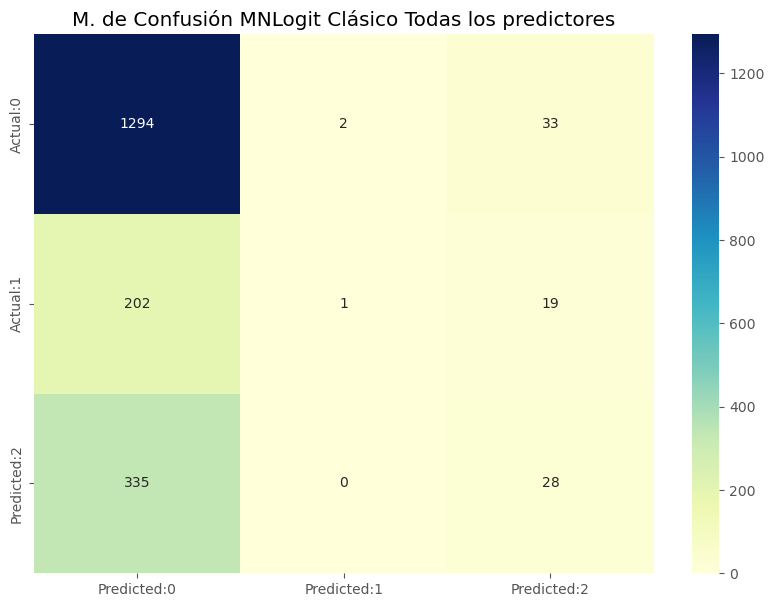

In [20]:
cm=confusion_matrix(Y,RESULT.predict(X).idxmax(axis=1)) ###idmax extrae la columna cuando axis=1 si no se coloca extrae las filas
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1', 'Predicted:2'],index=['Actual:0','Actual:1','Predicted:2'])
plt.figure(figsize = (10,7))
plt.title('M. de Confusión MNLogit Clásico Todas los predictores')
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [21]:
print("------------------------------------------------------")
print("AIC")
print(RESULT.aic)
print("------------------------------------------------------")
print(metrics.classification_report(Y,RESULT.predict(X).idxmax(axis=1)))
print("------------------------------------------------------")

------------------------------------------------------
AIC
2976.843987939837
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1329
           1       0.33      0.00      0.01       222
           2       0.35      0.08      0.13       363

    accuracy                           0.69      1914
   macro avg       0.46      0.35      0.32      1914
weighted avg       0.60      0.69      0.59      1914

------------------------------------------------------


## Solo Variables Significativas 

In [22]:
data2 = data1.drop(['Temp2',  'Dia_Semana_lunes', 'Dia_Semana_martes', 'Dia_Semana_miércoles', 'Dia_Semana_sábado', 'Refrigeracion_AMONIACO', 'TIPO_CAP_CF_C2'], axis=1)	

In [23]:
model2=sm.MNLogit(data2["Rechazados_Multiclass"], data2.drop(["Rechazados_Multiclass"], axis=1))

Optimization terminated successfully.
         Current function value: 0.760572
         Iterations 7


<AxesSubplot:title={'center':'M. de Confusión MNLogit Clásico Todas los predictores'}>

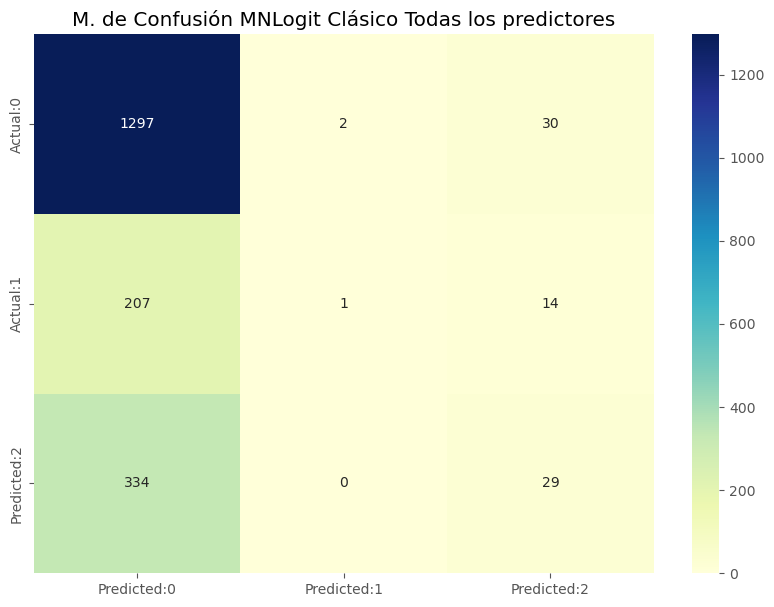

In [24]:
cm=confusion_matrix(data2["Rechazados_Multiclass"],model2.fit().predict(data2.drop(["Rechazados_Multiclass"], axis=1)).idxmax(axis=1)) ###idmax extrae la columna cuando axis=1 si no se coloca extrae las filas
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1', 'Predicted:2'],index=['Actual:0','Actual:1','Predicted:2'])
plt.figure(figsize = (10,7))
plt.title('M. de Confusión MNLogit Clásico Todas los predictores')
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [25]:
A=model2.fit()

Optimization terminated successfully.
         Current function value: 0.760572
         Iterations 7


In [26]:
print("------------------------------------------------------")
print("AIC")
print(A.aic)
print("------------------------------------------------------")
print(metrics.classification_report(data2["Rechazados_Multiclass"],A.predict(data2.drop(["Rechazados_Multiclass"], axis=1)).idxmax(axis=1)))
print("------------------------------------------------------")

------------------------------------------------------
AIC
2971.4678985080336
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.98      0.82      1329
           1       0.33      0.00      0.01       222
           2       0.40      0.08      0.13       363

    accuracy                           0.69      1914
   macro avg       0.48      0.35      0.32      1914
weighted avg       0.60      0.69      0.59      1914

------------------------------------------------------


===============================================================================================================================================================

# MACHINE LEARNING

===============================================================================================================================================================

In [27]:
# Dividimos los conjuntos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=1234) #1234 65
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [28]:
#Entrenamosel modelo y obtenemos accuracy
logit_model= sm.MNLogit(y_train, X_train)
res3 = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.752427
         Iterations 7


### Métricas para el conjunto de entrenamiento 

<AxesSubplot:title={'center':'M. de Confusión MNLogit Clásico Todas los predictores'}>

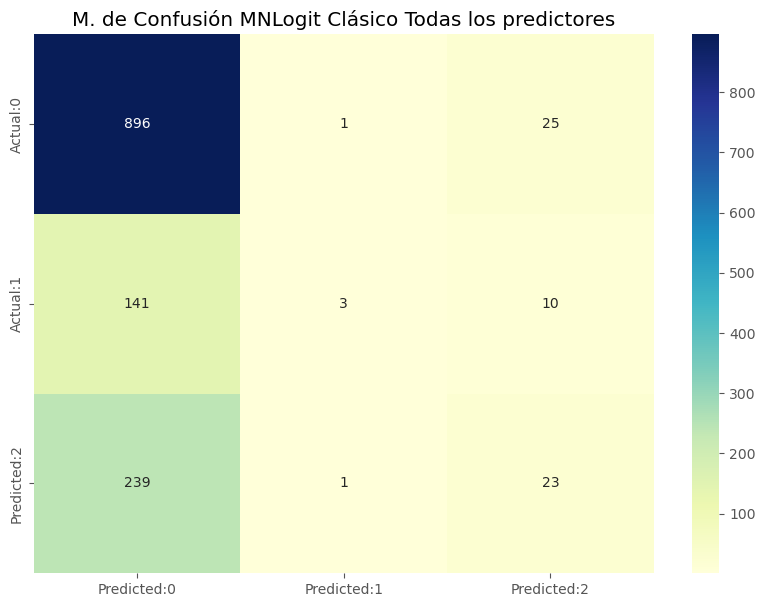

In [29]:
cm=confusion_matrix(y_train,res3.predict(X_train).idxmax(axis=1)) ###idmax extrae la columna cuando axis=1 si no se coloca extrae las filas
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1', 'Predicted:2'],index=['Actual:0','Actual:1','Predicted:2'])
plt.figure(figsize = (10,7))
plt.title('M. de Confusión MNLogit Clásico Todas los predictores')
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [30]:
print("------------------------------------------------------")
print("AIC")
print("------------------------------------------------------")
print(res3.aic)
print(metrics.classification_report(y_train,res3.predict(X_train).idxmax(axis=1)))
print("------------------------------------------------------")

------------------------------------------------------
AIC
------------------------------------------------------
2102.9988939638934
              precision    recall  f1-score   support

           0       0.70      0.97      0.82       922
           1       0.60      0.02      0.04       154
           2       0.40      0.09      0.14       263

    accuracy                           0.69      1339
   macro avg       0.57      0.36      0.33      1339
weighted avg       0.63      0.69      0.59      1339

------------------------------------------------------


### Métricas para el conjunto de prueba

<AxesSubplot:title={'center':'M. de Confusión MNLogit Clásico Todas los predictores'}>

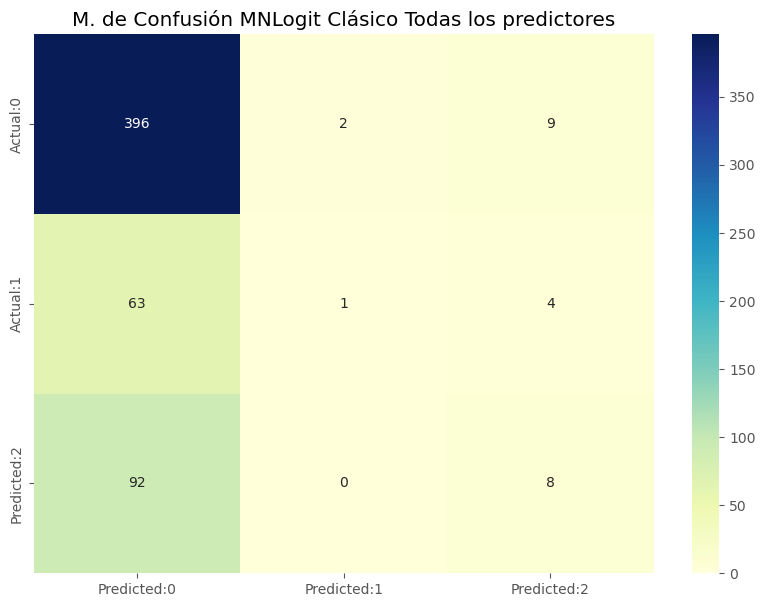

In [31]:
cm=confusion_matrix(y_test,res3.predict(X_test).idxmax(axis=1)) ###idmax extrae la columna cuando axis=1 si no se coloca extrae las filas
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1', 'Predicted:2'],index=['Actual:0','Actual:1','Predicted:2'])
plt.figure(figsize = (10,7))
plt.title('M. de Confusión MNLogit Clásico Todas los predictores')
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [32]:
print("------------------------------------------------------")
print("AIC")
print("------------------------------------------------------")
print(res3.aic)
print(metrics.classification_report(y_test,res3.predict(X_test).idxmax(axis=1)))
print("------------------------------------------------------")

------------------------------------------------------
AIC
------------------------------------------------------
2102.9988939638934
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       407
           1       0.33      0.01      0.03        68
           2       0.38      0.08      0.13       100

    accuracy                           0.70       575
   macro avg       0.48      0.36      0.33       575
weighted avg       0.61      0.70      0.61       575

------------------------------------------------------


### Métricas para todo el conjunto de datos

In [33]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     Rechazados_Multiclass   No. Observations:                 1339
Model:                           MNLogit   Df Residuals:                     1295
Method:                              MLE   Df Model:                           42
Date:                   Wed, 19 Jul 2023   Pseudo R-squ.:                 0.08834
Time:                           22:56:20   Log-Likelihood:                -1007.5
converged:                          True   LL-Null:                       -1105.1
Covariance Type:               nonrobust   LLR p-value:                 1.271e-21
===========================================================================================
Rechazados_Multiclass=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       8.4815      2.930      2.895      0.004       2.739      14.224
Temp1                      -0.2231      0.076     -2.916      0.004      -0.373      -0.073
Temp2                       0.0148      0.029      0.512      0.609      -0.042       0.072
Ti1                         0.0715      0.084      0.855      0.393      -0.092       0.235
Temp3                      -0.1275      0.053     -2.412      0.016      -0.231      -0.024
Ti2                         0.0238      0.007      3.545      0.000       0.011       0.037
PPPCF                      -0.0360      0.013     -2.753      0.006      -0.062      -0.010
Ocupacion                  -0.0096      0.011     -0.897      0.370      -0.031       0.011
Tamin                      -0.3145      0.094     -3.353      0.001      -0.498      -0.131
Taamax                     -0.0562      0.056     -1.009      0.313      -0.165       0.053
Franja2_MAÑANA             -0.4699      0.339     -1.386      0.166      -1.135       0.195
Franja2_MEDIO_DIA          -0.3582      0.283     -1.265      0.206      -0.913       0.197
Franja2_NOCHE              -0.4228      0.229     -1.842      0.065      -0.873       0.027
Dia_Semana_lunes            0.3154      0.309      1.019      0.308      -0.291       0.922
Dia_Semana_martes           0.0096      0.314      0.031      0.975      -0.606       0.625
Dia_Semana_miércoles        0.1694      0.301      0.563      0.573      -0.420       0.759
Dia_Semana_sábado          -0.6590      0.347     -1.898      0.058      -1.339       0.021
Dia_Semana_viernes         -0.4030      0.331     -1.218      0.223      -1.051       0.245
Refrigeracion_AMONIACO     -0.0156      0.223     -0.070      0.944      -0.453       0.422
pH_Requisito_Mi_5.8         0.2744      0.217      1.266      0.205      -0.150       0.699
TIPO_CAP_CF_C2              0.7070      0.470      1.505      0.132      -0.214       1.628
TIPO_CAP_CF_C3              0.7036      0.394      1.785      0.074      -0.069       1.476
-------------------------------------------------------------------------------------------
Rechazados_Multiclass=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.7657      2.601     -1.063      0.288      -7.864       2.332
Temp1                       0.0376      0.048      0.782      0.434      -0.057       0.132
Temp2                      -0.0260      0.025     -1.051      0.293      -0.074       0.022
Ti1                        -0.2141      0.099     -2.170      0.030      -0.407      -0.021
Temp3                      -0.1154      0.045     -2.557      0.011      -0.204      -0.027
Ti2                         0.0324      0.006      5.874      0.000       0.022       0.043
PPPCF                      -0.0015      0.007     -0.203      0.839      -0.016       

In [34]:
data["Temp1"].describe()

count    1914.000000
mean        3.080371
std         1.614204
min        -4.700000
25%         2.100000
50%         2.900000
75%         3.900000
max        18.200000
Name: Temp1, dtype: float64

In [35]:
print("Número de Veces que Temp1 <0°C :",len(data[data["Temp1"]<0]))

Número de Veces que Temp1 <0°C : 26
